# Setting up the mountain car environment:

In [4]:
#Import gym and setting up the envirmoment
import gym
import torch
import math
env=gym.envs.make('MountainCar-v0')


In [5]:
#Action space (left=0, mo push=1, right=2)
n_action=env.action_space.n


In [6]:
#Naive aprroach lets just push the car right, does not solve it the cart needs momentum  to climb the hill!

is_done=False
env.reset()
while not is_done:
    state,reward, is_done,_=env.step(2)
    print(state,reward,is_done)
    env.render()
    if is_done:
        break
env.close()

[-0.55434428  0.00123952] -1.0 False
[-0.5518745   0.00246978] -1.0 False
[-0.5481929  0.0036816] -1.0 False
[-0.54332701  0.00486589] -1.0 False
[-0.53731325  0.00601376] -1.0 False
[-0.53019666  0.00711659] -1.0 False
[-0.52203059  0.00816607] -1.0 False
[-0.51287628  0.00915431] -1.0 False
[-0.50280237  0.01007391] -1.0 False
[-0.49188434  0.01091803] -1.0 False
[-0.4802038   0.01168053] -1.0 False
[-0.46784781  0.01235599] -1.0 False
[-0.454908    0.01293981] -1.0 False
[-0.44147974  0.01342826] -1.0 False
[-0.42766116  0.01381858] -1.0 False
[-0.41355222  0.01410894] -1.0 False
[-0.39925371  0.0142985 ] -1.0 False
[-0.38486632  0.0143874 ] -1.0 False
[-0.37048964  0.01437668] -1.0 False
[-0.35622132  0.01426832] -1.0 False
[-0.34215624  0.01406508] -1.0 False
[-0.32838577  0.01377047] -1.0 False
[-0.31499713  0.01338864] -1.0 False
[-0.30207286  0.01292427] -1.0 False
[-0.28969041  0.01238245] -1.0 False
[-0.2779218   0.01176861] -1.0 False
[-0.26683342  0.01108838] -1.0 False
[-0

# ESTIMATING Q-FUNCTIONS(STATE, ACTION) WITH GRADIENT DESCENT

In [7]:
import torch
from torch.autograd import Variable
import math

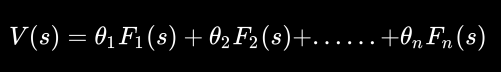

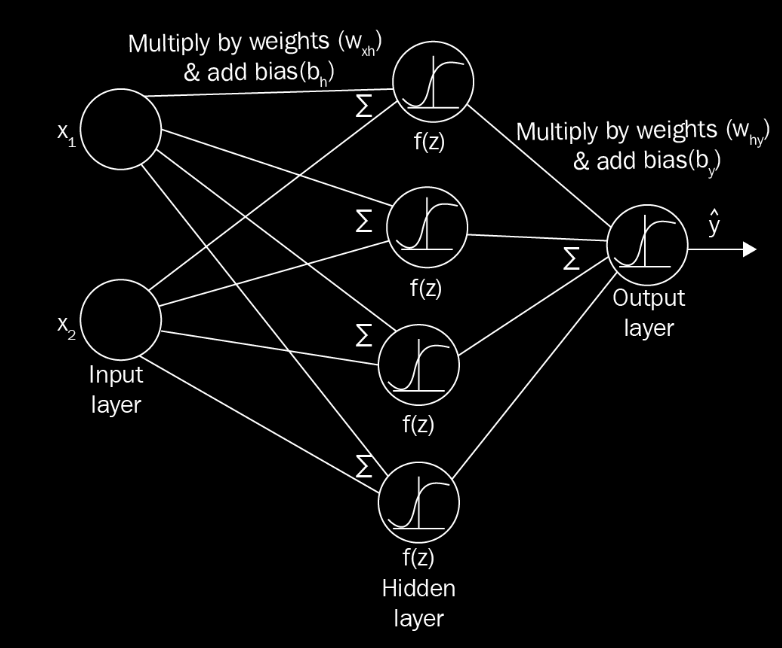

In [8]:
# Remeber how neural networks work. Estimate z , then transform z using the activation function fx. softmax. 
#The use another set of wights and biases to estimate z2. The we again a appy another activation function to get y
#To see how good your prediction is you minimize the square error. Changing the weigths
#We need a function aproximation because there are too many state value states


In [62]:
class Estimator():
    def __init__(self,n_feat,n_state,n_action,lr=0.05):
    #1.The get_gaussian_wb is a method within our class that takes the number that generates randoms Weigths(w) and Biases(b)) to train a neural network
        self.w,self.b=self.get_gaussian_wb(n_feat,n_state)
    #2.n_feat is the number of features of my model. (Number of independent variables in a regresion Each feuture changes value depending on the state it is in)    
        self.n_feat=n_feat
    #3.Empty Listis to copy the models to be updates
        self.models=[]
        self.optimizers=[]
    #4.Criterio que optimize the function. Minimum square error.    
        self.criterion=torch.nn.MSELoss()
        for _ in range(n_action):
    #5. This initializes a Linear model with n_feats and a bias and 1 output fx. y=g_1*F_1 + g_2*F2 +Bias        
            model=torch.nn.Linear(n_feat,1)
            self.models.append(model)
    #6.This is applygin gradient decent to the ;weights' and 'B' of my model. and updating them at the end lopps inside the function.
    #7.The momentum parameters inside SGD allows us to scape local minimums. This is great! we don't have to do the whole gradient decent algorithm!
            optimizer=torch.optim.SGD(model.parameters(),lr)
            self.optimizers.append(optimizer)
    #8.This method Generates random w and b to calculate the feats I want   
    def get_gaussian_wb(self,n_feat,n_state,sigma=.2):
        torch.manual_seed(0)
    #9.This is a matrix of weight rows=n_state and columns=n_feats Estoy estimate valrios modelos para Cada Feat
    #10. Estoy estimando un modelo para cada uno de los estados!!!!!!!!!! con los feats
        w=torch.randn((n_state,n_feat))*1.0/sigma
        b=torch.rand(n_feat)*2.0*math.pi
        return w,b
    #11.This method estimate the Feature F that we are going to use in the 'regression' to Predict the Q(state,action). Its a formula
    #12. It usses a Cosine transormation
    def get_feature(self,s):
        features=(2.0/self.n_feat)**.5*torch.cos(torch.matmul(torch.tensor(s).float(),self.w)+self.b)
        return features
    #13. takes state (s), actions(a), predicts Q (y)
    def update(self,s,a,y):
    #14. 'features' is a tensor (n_states ,1) Is the the 'predicted' value of the Q-function for all states after taking action 'A'   
        features=Variable(self.get_feature(s))
    #15. I insert the features into the the model of action 'A'    
        y_pred=self.models[a](features)
    #16. The 'vARIABLE' method from torch.autograd computes the derivative of the loss function!!! yey!
        loss=self.criterion(y_pred,Variable(torch.Tensor([y])))
        self.optimizers[a].zero_grad()
        loss.backward()
        self.optimizers[a].step()
    def predict(self,s):
        features=self.get_feature(s)
    #This basically evaluates the model return ta prediction
    #I apply the function torch.no_grad() to 'model(features)'
        with torch.no_grad():
            return torch.tensor([model(features) for model in self.models])

In [63]:
#Creating an estimator object with:
n_feat=10
n_state=2
n_action=1

#Initlizing it
estimator=Estimator(10,2,1)
estimator

In [64]:
#Generating features out of a single state. I end up with 10 feutures for a single state, It is independet of the action I take
#It only takes into account the random weights and biases
s1=[0.5,0.1]
print(estimator.get_feature(s1))

tensor([ 0.3163, -0.4467, -0.0450, -0.1490,  0.2393, -0.4181, -0.4426,  0.3074,
        -0.4451,  0.1808])


In [91]:
#training the estimator with a set of states. ( we only have 1 action in this example)

s_list=[[1,2],[2,2],[3,4],[2,3],[2,1]]
target_list=[1,1.5,2,2,1.5]

for s,target in zip(s_list,target_list):
    feature=estimator.get_feature(s)
    #We only have 1 Action in this case. that is why a=0
    estimator.update(s,0,target)


In [92]:
#Porque tenia una sola action, me regreso un solor tensor. Si tuviera mas actions el seria rtan grande como el nnumero posbile de actions
print(estimator.predict([2,2]))

tensor([1.5526])


# Q-Leaning with linear function Aproximation 

In [14]:
# As always use the epsilon greedy function creator. Creates a vector of probabilies looks into the q function for every state and selects the best actions
#Selecting the best actions gives it the largest probabilities
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        probs=torch.ones(n_action)*epsilon/n_action
        q_values=estimator.predict(state)
        best_action=torch.argmax(q_values).item()
        probs[best_action]+=1.0-epsilon
        action=torch.multinomial(probs, 1).item()
        return action
    return policy_function
    

In [15]:
#Testing my policy
episode=1
epsilon=0.1
epsilon_decay=.99

#Running the estimator class which the Q Learning for a specfic sate
n_state=env.observation_space.shape[0]
n_action=env.action_space.n
n_feature=200
lr=0.03
estimator=Estimator(n_feature,n_state,n_action,lr)

#Initial random state
state-env.reset()

#Looking at the policy vector, which just an action
policy=gen_epsilon_greedy_policy(estimator,epsilon*epsilon_decay**episode,n_action)
policy(state)

2

In [16]:
n_state=env.observation_space.shape[0]
n_action=env.action_space.n
n_feature=200
lr=0.03
estimator=Estimator(n_feature,n_state,n_action,lr)
n_episode=300
total_reward_episode=[0]*n_episode



def q_learning(env,estimator, n_episode,gamma=1.0,epsilon=0.1 , epsilon_decay=.99):
    for episode in range(n_episode):
    #1. As I go smaller and smaller I explore less. If epsilon=0 , I only choose best policy and do not explore random actions.
        policy=gen_epsilon_greedy_policy(estimator,epsilon*epsilon_decay**episode,n_action)
        state=env.reset()
        is_done=False
        while not is_done:
            action=policy(state)
            next_state,reward,is_done,_=env.step(action)
            q_values_next=estimator.predict(next_state)
            td_target=reward+gamma*torch.max(q_values_next)
    # I am training the estimator here with the basically adding an observation. This changes the weights. td_target is bally true y, 
    # After adjusting the 'weights' and 'b' getting the New estimates we will me able to to do a new estimate for the next states
            estimator.update(state,action,td_target)
            total_reward_episode[episode]+=reward
            if is_done:
                break
            state=next_state


In [17]:
q_learning(env,estimator, n_episode,gamma=1.0,epsilon=0.1 , epsilon_decay=.99)

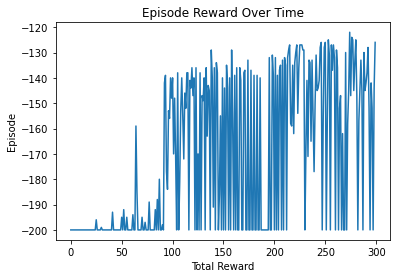

In [18]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode Reward Over Time')
plt.ylabel('Episode')
plt.xlabel('Total Reward')
plt.show()

In [19]:
total_reward_episode

[-200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -196.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -199.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -193.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -195.0,
 -200.0,
 -192.0,
 -200.0,
 -200.0,
 -195.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -194.0,
 -200.0,
 -200.0,
 -159.0,
 -185.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -195.0,
 -200.0,
 -200.0,
 -197.0,
 -200.0,
 -200.0,
 -200.0,
 -189.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -192.0,
 -200.0,
 -188.0,
 -200.0,
 -180.0,
 -200.0,
 -200.0,
 -198.0,
 -200.0,
 -142.0,
 -139.0,
 -177.0,
 -184.0,
 -153.0,
 -156.0,
 -140.0,
 -148.0,
 -140.0,
 -170.0,
 -148.0,
 -171.0,
 -200.0,
 -138.0,
 -200.0,
 -181.0,
 -153.0,
 -140.0,
 -155.0,
 

# SARSA Learning Aproximation

In [2]:
def sarsa(env,estimator,n_episode,gamma=1.0,epsilon=0.1,epsilon_decay=.99):
    for episode in range(n_episode):
        policy=gen_epsilon_greedy_policy(estimator,epsilon*epsilon_decay**episode,n_action)
        state=env.reset()
    #In sarsa we take future states
        action=policy(state)
        is_done=False
        while not is_done:
            next_state, reward, done,_=env.step(action)
            q_values_next=estimator.predict(next_state)
            next_action=policy(next_state)
            td_target=reward + gamma*q_values_next[next_action]
            estimator.update(state, action, td_target)
            total_reward_episode[episode]+= reward
            if is_done:
                break
            state = next_state
            action= next_action
            
        

In [3]:
n_state=env.observation_space.shape[0]
n_action=env.action_space.n
n_feature=200
lr=0.03
estimator=Estimator(n_feature,n_state,n_action,lr)
n_episode=300
total_reward_episode=[0]*n_episode



sarsa(env,estimator,n_episode,gamma=1.0,epsilon=0.1,epsilon_decay=.99)

NameError: name 'Estimator' is not defined

# Function Aproximation with Neural Networks

In [25]:
#Import Packages
import torch
from torch.autograd import Variable
from collections import deque
import random
import math
import gym

#Create Environment
env=gym.envs.make('MountainCar-v0')


In [94]:
#The estimator class is excatly and the linear aproximatio he same it only changes the initializion
class Estimator():
    def __init__(self,n_feat,n_state,n_action,n_hidden,lr=0.05):
        self.w,self.b=self.get_gaussian_wb(n_feat,n_state)
        self.n_feat=n_feat
        self.models=[]
        self.optimizers=[]
        self.criterion=torch.nn.MSELoss()
        for _ in range(n_action):
    #1.This initializes a neural network with n_featsm n_hidden Layers , actiavtion function is Relu, The last Layer torch.nn.Linear(n_hidden,1) , has '1' autput and is connected with the n_hidden i the number of nodes   
            model=torch.nn.Sequential(torch.nn.Linear(n_feat,n_hidden),torch.nn.ReLU(),torch.nn.Linear(n_hidden,1))
            self.models.append(model)
            optimizer=torch.optim.Adam(model.parameters(),lr)
            self.optimizers.append(optimizer)
    def get_gaussian_wb(self,n_feat,n_state,sigma=.2):
        torch.manual_seed(0)
        w=torch.randn((n_state,n_feat))*1.0/sigma
        b=torch.rand(n_feat)*2.0*math.pi
        return w,b
    def get_feature(self,s):
        features=(2.0/self.n_feat)**.5*torch.cos(torch.matmul(torch.tensor(s).float(),self.w)+self.b)
        return features
    def update(self,s,a,y):
        features=Variable(self.get_feature(s))
        y_pred=self.models[a](features)
        loss=self.criterion(y_pred,Variable(torch.Tensor([y])))
        self.optimizers[a].zero_grad()
        loss.backward()
        self.optimizers[a].step()
    def predict(self,s):
        features=self.get_feature(s)
        with torch.no_grad():
            return torch.tensor([model(features) for model in self.models])

In [162]:
#Initlizing it with 50 hidden layers
estimator=Estimator(10,2,1,1000)

In [199]:

#training the estimator with a set of states. ( we only have 1 action in this example)

s_list=[[1,2],[2,2],[3,4],[2,3],[2,1]]
target_list=[1,1.5,2,2,1.5]

for s,target in zip(s_list,target_list):
    feature=estimator.get_feature(s)
    #We only have 1 Action in this case. that is why a=0
    estimator.update(s,0,target)


In [200]:
#Porque tenia una sola action, me regreso un solor tensor. Si tuviera mas actions el seria rtan grande como el nnumero posbile de actions
print(estimator.predict([1,2]))

tensor([1.0265])


In [121]:

#Testing Q learning algorithm

#Initial Values
n_state=env.observation_space.shape[0]
n_action=env.action_space.n
n_feature=200
lr=0.03
n_episode=300
total_reward_episode=[0]*n_episode

#This is the only difference
n_hidden=50
estimator=Estimator(n_feature,n_state,n_action,n_hidden,lr)

In [28]:
q_learning(env,estimator, n_episode,gamma=1.0,epsilon=0.1 , epsilon_decay=.99)

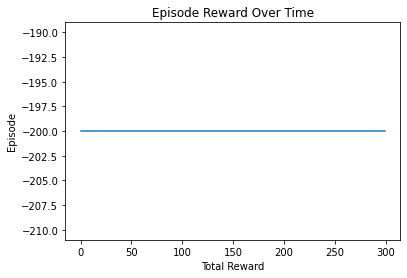

In [30]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode Reward Over Time')
plt.ylabel('Episode')
plt.xlabel('Total Reward')
plt.show()

In [31]:
total_reward_episode

[-200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 -200.0,
 